### How to load the data

This jupyter notebook demonstrates how to access the data of the dataset. To run the notebook you will need to install the following packages:
- pymef (to read MEF3 format)
- pybids (to load the BIDS data structure)


Let's do the imports first

In [391]:
import os

from pymef import MefSession
from bids import BIDSLayout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt


SETTINGS

In [392]:
APPLY_LOW_PASS_FILTER = True
LSTM_READY = False
FEATURE_SET = 3
subject = '004'
run = 1

Now load the BIDS dataset

In [393]:
path_to_dataset = r"C:\MasterThesis\v1.0"  # Please change this value

l = BIDSLayout(path_to_dataset)

Define what data we want to load

In [394]:
filter_dictionary = {'subject': subject,
                     'session': '001',
                     'task': 'FR',
                     'run': run,
                     'suffix': 'ieeg',
                     'extension': 'json'}
json_files = l.get(**filter_dictionary)

# We now we have requested only one file now but multiple files can be processed in a for loop
json_file = json_files[0]
print(json_file)

json_entities = json_file.entities

<BIDSJSONFile filename='C:\MasterThesis\v1.0\sub-004\ses-001\ieeg\sub-004_ses-001_task-FR_run-01_ieeg.json'>


Load information about channels

In [395]:
# Get channels
channel_file = l.get(suffix='channels', extension='tsv',
                     task=json_entities['task'],
                     subject=json_entities['subject'],
                     session=json_entities['session'],
                     run=json_entities['run'])[0]
channel_df = channel_file.get_df()
channel_df = channel_df[channel_df['status'] != 'bad']
channel_df
    

,name,type,units,low_cutoff,high_cutoff,reference,sampling_frequency,status,status_description
0,LAM_01,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
2,LAM_03,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
3,LAM_04,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
4,LAM_05,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
5,LAM_06,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
...,...,...,...,...,...,...,...,...,...
132,RIGHT_PUPIL_SIZE,PUPIL,px2,NaN,NaN,scalp_cpz,150,good,NaN
133,RIGHT_X_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
134,RIGHT_Y_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
135,SCREEN_X,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN


Load events

In [396]:
events_file = l.get(suffix='events', extension='tsv',
                    task=json_entities['task'],
                    subject=json_entities['subject'],
                    session=json_entities['session'],
                    run=json_entities['run'])[0]
events_df = events_file.get_df()

# Pull only the processed events (discarding the original events)
events_df = events_df.loc[~events_df['trial_type'].isna(), ['onset', 'sample', 'duration', 'trial_type', 'list']]
events_df = events_df[events_df['trial_type'] == 'ENCODE']
events_df = events_df.reset_index(drop=True)
events_df


,onset,sample,duration,trial_type,list
0,375.780287,12024969,1.494031,ENCODE,1.0
1,378.278411,12104909,1.495906,ENCODE,1.0
2,380.786316,12185162,1.488000,ENCODE,1.0
3,383.279534,12264945,1.494781,ENCODE,1.0
4,385.780283,12344969,1.494031,ENCODE,1.0
...,...,...,...,...,...
175,1924.491728,61583735,1.495061,ENCODE,15.0
176,1926.991914,61663741,1.494906,ENCODE,15.0
177,1929.494851,61743835,1.491968,ENCODE,15.0
178,1931.994350,61823819,1.492468,ENCODE,15.0


Now load the raw data

In [397]:
# Since we are using MEF3 pybids has problems recognizing the extension so we need to modify the json extension
mef_session_path = os.path.splitext(json_file.path)[0]+'.mefd'
print(mef_session_path)
ms = MefSession(mef_session_path, None)
ms.read_ts_channel_basic_info()

C:\MasterThesis\v1.0\sub-004\ses-001\ieeg\sub-004_ses-001_task-FR_run-01_ieeg.mefd


[{'name': 'LAM_01',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LAM_02',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LAM_03',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')}

Now load the data from encoding events

In [398]:
channels = ['LEFT_PUPIL_SIZE', 'RIGHT_PUPIL_SIZE']

# Microseconds 1 μs = 10⁻⁶ s
start_time = 1553941347170839+3*1e6  # in microseconds
end_time = 1553942904095135-3*1e6
win_size = 10  # in seconds
stop_time = start_time + int(win_size*1e6)

bi = ms.read_ts_channel_basic_info()

# In this case we are reading MEF records instead of data from events.tsv because we do not have to make time conversions this way
records = ms.read_records()
records_in_win = [x for x in records if start_time < x['time'] < stop_time]
# The code to get corresponding events from the events file
session_metadata = ms.session_md
session_start_utc = session_metadata['session_specific_metadata']['earliest_start_time'][0]
print(f"session_start_utc = {session_start_utc}\nsession_stop_utc = {stop_time}")
events_df['microsecond_onset'] = events_df['onset']*1e6
events_df['uutc'] = (events_df['microsecond_onset'] + session_start_utc).astype('int64')
events_in_win = events_df[(start_time < events_df['uutc'])
                          & (events_df['uutc'] < stop_time)]
events_df.head()

session_start_utc = 1553940917170848
session_stop_utc = 1553941360170839.0


,onset,sample,duration,trial_type,list,microsecond_onset,uutc
0,375.780287,12024969,1.494031,ENCODE,1.0,375780287.0,1553941292951135
1,378.278411,12104909,1.495906,ENCODE,1.0,378278411.0,1553941295449259
2,380.786316,12185162,1.488000,ENCODE,1.0,380786316.0,1553941297957164
3,383.279534,12264945,1.494781,ENCODE,1.0,383279534.0,1553941300450382
4,385.780283,12344969,1.494031,ENCODE,1.0,385780283.0,1553941302951131


In [399]:
# records_in_events = [x for x in records if (0 < (x['time'] - events_df['uutc']) < 150000)]
records_in_events = []
for x in records:
    for e in events_df['uutc']:
        # print(x['time'] - e)
        if 0 == (x['time'] - e):
            records_in_events.append(x)

len(records_in_events)
data_events = []
# −200ms to 0ms from the onset and from 1000ms to 1400ms
for e in events_df['uutc']:
    data_events.append(ms.read_ts_channels_uutc(channels, [e - 600000, e + 900000]))
data_events = np.array(data_events)
data_events.shape

(180, 2, 225)

In [400]:
print(data_events[0])

[[2.62179400e+08 2.62737600e+08 2.58605400e+08 2.57709600e+08
  2.49716600e+08 2.55793200e+08 2.52613199e+08 2.52761099e+08
  2.55102800e+08 2.55200399e+08 2.50056100e+08 2.51856000e+08
  2.51134200e+08 2.51664000e+08 2.51664000e+08 2.51177600e+08
  2.52238000e+08 2.48923799e+08 2.48870999e+08 2.49504000e+08
  2.53387400e+08 2.48895200e+08 2.52428400e+08 2.51983200e+08
  2.48171000e+08 2.43966000e+08 2.44111999e+08 2.44111999e+08
  2.44111999e+08 2.43942400e+08 2.43321600e+08 2.39275999e+08
  2.40715800e+08 2.40842100e+08 2.41444800e+08 2.35046000e+08
  2.37269000e+08 2.41702500e+08 2.41147999e+08 2.34028800e+08
  2.32010200e+08 2.33168400e+08 2.32212499e+08 2.33549700e+08
  2.33549700e+08 2.29532400e+08 2.42818200e+08 2.35805199e+08
  2.29795200e+08 2.33387400e+08 2.37345299e+08 2.37345299e+08
  2.33693599e+08 2.25373500e+08 2.25373500e+08 2.29136700e+08
  2.30383200e+08 2.29290600e+08 2.32537500e+08 2.32862500e+08
  2.30907600e+08 2.24490099e+08 2.31091200e+08 2.30340600e+08
  2.2947

## Artefacts cutout

In [401]:
def check_missing_values(arr):
    """Check if a numpy array has missing values."""
    if np.isnan(arr).any():
        print("The array has missing values.")
        return True
    else:
        return False

In [402]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        missing_values_idx = []
        for sample_idx, sample in enumerate(channel):
            if np.isnan(sample):
                missing_values_idx.append(sample_idx)
        print(missing_values_idx)
        for missing in missing_values_idx[::-1]:
            if missing >= 5:
                for i in range(5):
                    data_events[s_idx][ch_idx][missing-i] = np.nan
            if missing <= 221:
                for i in range(3):
                    data_events[s_idx][ch_idx][missing+i] = np.nan

[]
[]
[]
[]
[177, 178]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[174, 175, 176, 177, 178, 179, 182, 183, 184, 185, 186, 187, 189, 190]
[173, 174, 175, 176, 178, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224]
[205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224]
[]
[]
[]
[]
[]
[]
[158, 163, 167, 168, 171, 174]
[160, 161, 162, 163, 164, 165, 166, 167, 168]
[]
[]
[221]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49]
[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
[168, 169, 170, 171, 172, 174, 175, 176, 179, 182, 184, 192, 193, 194]
[169, 174, 175, 176, 179, 180, 184, 192, 193, 194]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[146, 149, 150, 151, 152, 153, 154, 155, 156, 186, 187, 188, 191,

## Apply linear interpolation if values are missing

In [403]:
how_many_nan = 0
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if check_missing_values(channel):
            how_many_nan += 1
            df = pd.DataFrame({'signal': channel})
            print(f"Apply linear interpolation to fill the missing values [{s_idx}][{ch_idx}]")
            df['signal'] = df['signal'].bfill().ffill().interpolate(method='linear')
            data_events[s_idx][ch_idx] = df['signal'].values.tolist()
            print(data_events[s_idx][ch_idx])
print(how_many_nan)

The array has missing values.
Apply linear interpolation to fill the missing values [2][0]
[2.60964200e+08 2.61617300e+08 2.56658800e+08 2.57313600e+08
 2.57745399e+08 2.51658000e+08 2.54001600e+08 2.54001600e+08
 2.54001600e+08 2.54001600e+08 2.63784000e+08 2.59589799e+08
 2.54490000e+08 2.57656000e+08 2.51262000e+08 2.51410499e+08
 2.51410499e+08 2.51410499e+08 2.51410499e+08 2.51410499e+08
 2.56329000e+08 2.59178400e+08 2.61403800e+08 2.51008000e+08
 2.54462399e+08 2.54462399e+08 2.54610000e+08 2.52938400e+08
 2.59749000e+08 2.61295100e+08 2.58215400e+08 2.55398400e+08
 2.56885200e+08 2.56885200e+08 2.56885200e+08 2.59828400e+08
 2.57423400e+08 2.57299200e+08 2.68052800e+08 2.58512800e+08
 2.61288000e+08 2.60414200e+08 2.65286200e+08 2.61403000e+08
 2.55740600e+08 2.54487100e+08 2.58438299e+08 2.67719999e+08
 2.66219999e+08 2.66067000e+08 2.66547100e+08 2.61936000e+08
 2.69079000e+08 2.68133999e+08 2.68790600e+08 2.62268000e+08
 2.62980900e+08 2.61117000e+08 2.62331300e+08 2.5641440

## Connect windows to continuous signal across channels

In [404]:
channel_1_raw = []
channel_2_raw = []
for s_idx, sequence in enumerate(data_events):
    for sample in data_events[s_idx][0]:
        channel_1_raw.append(sample)
    for sample in data_events[s_idx][1]:
        channel_2_raw.append(sample)
channel_1_raw = np.array(channel_1_raw)
channel_2_raw = np.array(channel_2_raw)
channel_1_raw.shape

(40500,)

### Apply z-score normalization

In [405]:
mean = np.mean(channel_1_raw)
std = np.std(channel_1_raw)
data_normalized = (channel_1_raw - mean) / std
channel_1_raw = data_normalized

mean = np.mean(channel_2_raw)
std = np.std(channel_2_raw)
data_normalized = (channel_2_raw - mean) / std
channel_2_raw = data_normalized

### Split again into windows

In [406]:
def split_list(lst, n):
    """Split the list, lst, into chunks of size n."""
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [407]:
samples_in_window = 225
chunks_1 = split_list(channel_1_raw, samples_in_window)
chunks_2 = split_list(channel_2_raw, samples_in_window)
print(len(chunks_1))

180


In [408]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if ch_idx == 0:
            data_events[s_idx][ch_idx] = chunks_1[s_idx]
        elif ch_idx == 1:
            data_events[s_idx][ch_idx] = chunks_2[s_idx]
data_events = np.array(data_events)
print(data_events.shape)

(180, 2, 225)


In [409]:
print(data_events[0][0][0])

-0.10617284734465653


## Plot the window

In [410]:
def plot_channels(data):
    # assuming 'data' is your list
    data = np.array(data)  # convert list to numpy array
    print(data.shape)
    time = np.arange(0, data.shape[1])  # creating a time vector

    # plotting the data
    plt.figure(figsize=(10,6))  # creating a new figure with specified size
    print(data[0])
    # plot for channel 1
    plt.subplot(2, 1, 1)  # creating the first subplot in a 2x1 grid
    plt.plot(time, data[0], color='blue')  # plotting the data for the first channel
    plt.title('Channel 1')  # setting the title of the first subplot
    plt.xlabel('Time')  # setting the x-label
    plt.ylabel('Amplitude')  # setting the y-label

    # plot for channel 2
    plt.subplot(2, 1, 2)  # creating the second subplot in a 2x1 grid
    plt.plot(time, data[1], color='red')  # plotting the data for the second channel
    plt.title('Channel 2')  # setting the title of the second subplot
    plt.xlabel('Time')  # setting the x-label
    plt.ylabel('Amplitude')  # setting the y-label

    plt.tight_layout()  # adjusting the layout so everything fits
    plt.show()  # displaying the figure

(2, 225)
[-0.10617285 -0.09834155 -0.15631445 -0.16888211 -0.28102027 -0.19576833
 -0.24038231 -0.23830734 -0.20545433 -0.20408506 -0.27625724 -0.25100546
 -0.26113199 -0.25369914 -0.25369914 -0.26052311 -0.24564618 -0.29214291
 -0.29288367 -0.28400296 -0.22952062 -0.29254414 -0.24297495 -0.24922091
 -0.30270434 -0.36169858 -0.35965028 -0.35965028 -0.35965028 -0.36202968
 -0.37073922 -0.42749717 -0.40729741 -0.40552548 -0.39706987 -0.48684213
 -0.45565445 -0.39345446 -0.40123386 -0.50111299 -0.52943303 -0.51318401
 -0.52659487 -0.50783454 -0.50783454 -0.56419544 -0.3778017  -0.47619092
 -0.56050847 -0.51011154 -0.45458401 -0.45458401 -0.50581571 -0.62254292
 -0.62254292 -0.56974693 -0.5522591  -0.56758778 -0.52203525 -0.51747565
 -0.54490201 -0.63493663 -0.54232618 -0.55285676 -0.56505406 -0.61461342
 -0.61461342 -0.60840254 -0.61237009 -0.56815177 -0.62254292 -0.67938643
 -0.63443717 -0.50541304 -0.55821887 -0.55366207 -0.55366207 -0.55366207
 -0.576996   -0.56332841 -0.5228644  -0.55

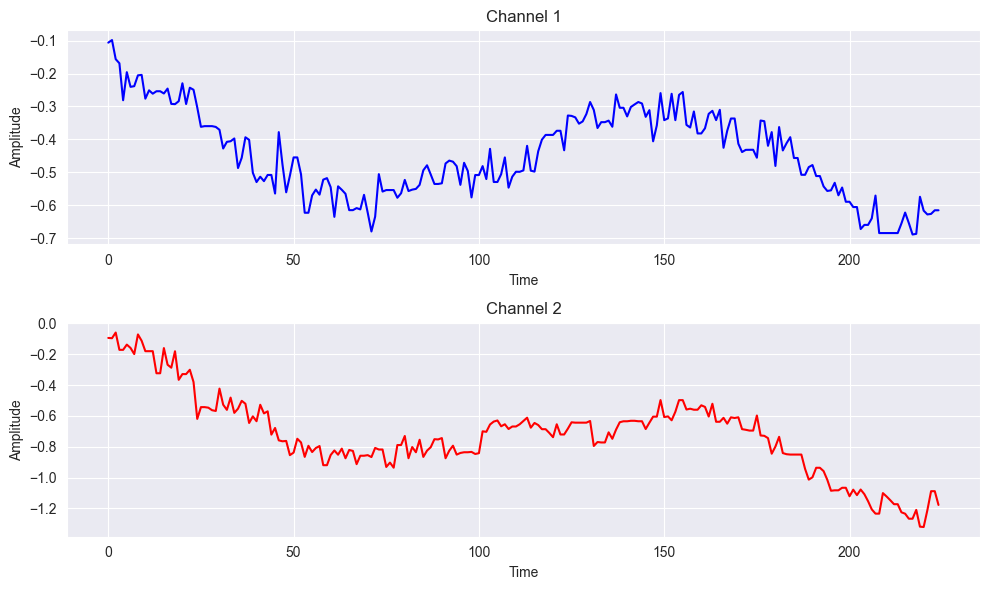

In [411]:
plot_channels(data_events[0])

## Define and apply butterworth filter

In [412]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Parameters
order = 3
fs = 150.0       # sample rate, Hz
cutoff = 30.0    # desired cutoff frequency of the filter, Hz


In [413]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        y = butter_lowpass_filter(channel, cutoff, fs, order)
        data_events[s_idx][ch_idx] = y

(2, 225)
[-0.10617593 -0.11668073 -0.1469437  -0.19193024 -0.22803054 -0.2400873
 -0.2328252  -0.22011331 -0.21538349 -0.22608075 -0.24612264 -0.26062476
 -0.26223586 -0.25597226 -0.25074276 -0.25333337 -0.26564502 -0.28074946
 -0.28658228 -0.278877   -0.26467    -0.2525512  -0.25012674 -0.2670301
 -0.30408302 -0.34333235 -0.36353565 -0.36279368 -0.3580811  -0.36559706
 -0.38466367 -0.40092112 -0.40714558 -0.41453384 -0.43223516 -0.44543366
 -0.43639845 -0.42042655 -0.43121562 -0.47232438 -0.51235071 -0.52837383
 -0.5277087  -0.52305507 -0.50982875 -0.48460669 -0.46931909 -0.48449822
 -0.50790328 -0.50138584 -0.47312588 -0.47221114 -0.52097289 -0.58401148
 -0.61250584 -0.59725904 -0.56397935 -0.53645729 -0.52567586 -0.53697001
 -0.56202595 -0.57688017 -0.57019123 -0.56126913 -0.57289489 -0.59921668
 -0.61490828 -0.60827695 -0.59603801 -0.60367969 -0.63010811 -0.64144682
 -0.61335625 -0.56619039 -0.53840057 -0.54083786 -0.55631187 -0.56672281
 -0.56486856 -0.55393378 -0.54526029 -0.5473

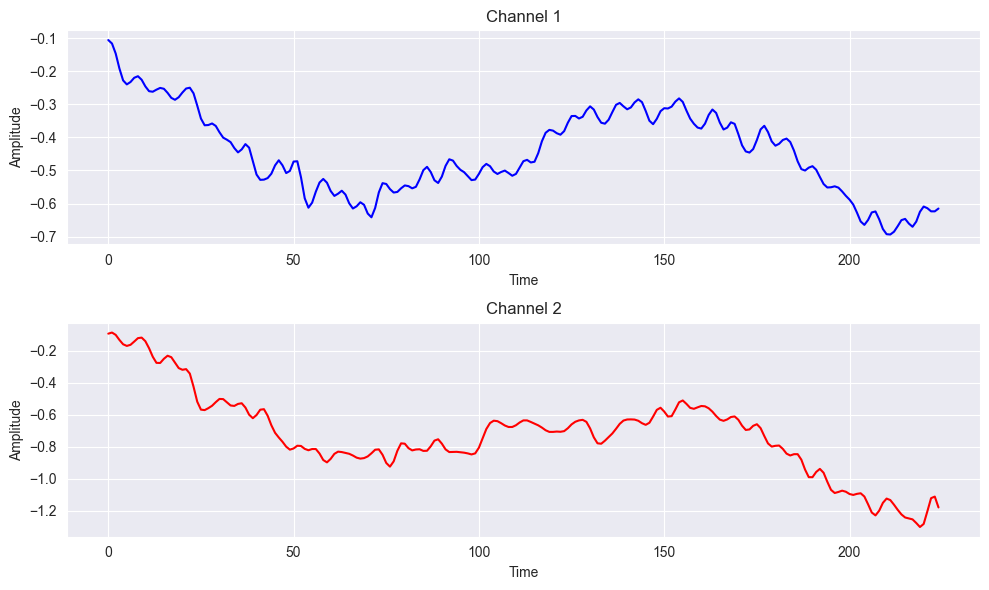

In [414]:
plot_channels(data_events[0])

## Feature extraction

### Feature set 1
https://www.hindawi.com/journals/cin/2020/2909267/

In [415]:
import scipy.fft


if FEATURE_SET == 1:
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Calculate Mean of the signal as a feature
            mean = np.mean(eeg_data)

            # Calculate Variance of the signal as a feature
            variance = np.var(eeg_data)

            # Calculate Standard Deviation of the signal as a feature
            std_dev = np.std(eeg_data)

            # Use Fast Fourier Transform to get the power spectrum of the signal
            power_spectrum = np.abs(scipy.fft.fft(eeg_data))**2

            # Frequency values for plotting the spectrum - assuming a sampling rate (fs) of 128 Hz
            freqs = scipy.fft.fftfreq(len(eeg_data), 1 / 128)

            # Let's use the mean power in specific frequency bands as features
            delta_power = np.mean(power_spectrum[(freqs >= 0.5) & (freqs <= 4)])
            theta_power = np.mean(power_spectrum[(freqs > 4) & (freqs <= 8)])
            alpha_power = np.mean(power_spectrum[(freqs > 8) & (freqs <= 12)])
            beta_power = np.mean(power_spectrum[(freqs > 12) & (freqs <= 30)])

            # Gather all features into a list
            features = [mean, variance, std_dev, delta_power, theta_power, alpha_power, beta_power]

            print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    print(len(data_events))
    print(len(data_events[0]))
    print(len(data_events[0][0]))

### Feature set 2 - 6 features
https://www.mdpi.com/2227-9032/11/3/322

In [416]:
from scipy.stats import skew, kurtosis, variation


if FEATURE_SET == 2 and not LSTM_READY:
    data_events = data_events.tolist()
    # Assuming 'eeg_data' is a NumPy array containing your EEG data.
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Assuming 'eeg_data' is a NumPy array containing your EEG data for one channel

            mean = np.mean(eeg_data)
            q1 = np.percentile(eeg_data, 25)
            q2 = np.percentile(eeg_data, 50)
            q3 = np.percentile(eeg_data, 75)
            min_signal = np.min(eeg_data)
            max_signal = np.max(eeg_data)
            # variance = variation(eeg_data)
            # skewness = skew(eeg_data)

            features = [mean, q1, q2, q3, min_signal, max_signal]

            # print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    data_events = np.array(data_events)
    print(data_events.shape)

### Feature set 3 - 4 features
https://www.hindawi.com/journals/cin/2020/2909267/

In [417]:

if FEATURE_SET == 3:
    data_events = data_events.tolist()
    # Assuming 'eeg_data' is a NumPy array containing your EEG data.
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Assuming 'eeg_data' is a NumPy array containing your EEG data for one channel

            mean = np.mean(eeg_data)
            variance = variation(eeg_data)
            skewness = skew(eeg_data)
            # kurtosis = kurtosis(eeg_data)

            features = [mean, variance, skewness]

            print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    data_events = np.array(data_events)
    print(data_events.shape)

Extracted features: [-0.4472231266399117, -0.286369065621456, 0.15550039165627205]
Extracted features: [-0.7235045202454747, -0.3555939785630217, 0.19557576163664847]
Extracted features: [-0.5929671958465923, -0.18965030907975927, -0.5585071697431391]
Extracted features: [-1.0171466846048849, -0.18251282740923397, -0.15672869188014782]
Extracted features: [-0.06224576972723311, -4.0955440206592915, -1.400769946738331]
Extracted features: [-0.2355716130118219, -1.0926155196933285, -0.6580422919479479]
Extracted features: [-0.7669837027276846, -0.2989095877753527, -0.14047141022241375]
Extracted features: [-1.2894115626079763, -0.27629092920284626, -0.009196558933983886]
Extracted features: [0.2370560458993881, 0.6947136189257013, -0.355878456308063]
Extracted features: [0.2680616738503862, 0.9882084778592102, -0.9600743888576121]
Extracted features: [0.014541627261633465, 15.110577118926997, -0.20506069464767626]
Extracted features: [-0.18114181584266156, -1.6605805278804284, 0.08351065

## Reshape to dataframe

In [418]:
arr = np.array(data_events)

    # Reshape the array to the required shape (180, 450)
arr_reshaped = arr.reshape(180, -1)  # -1 means calculate the size of this dimension

df = pd.DataFrame(arr_reshaped)

    # Now df is a DataFrame with shape (180, 450)
print(df.shape)

(180, 6)


In [419]:
df.head()

,0,1,2,3,4,5
0,-0.447223,-0.286369,0.155500,-0.723505,-0.355594,0.195576
1,-0.592967,-0.189650,-0.558507,-1.017147,-0.182513,-0.156729
2,-0.062246,-4.095544,-1.400770,-0.235572,-1.092616,-0.658042
3,-0.766984,-0.298910,-0.140471,-1.289412,-0.276291,-0.009197
4,0.237056,0.694714,-0.355878,0.268062,0.988208,-0.960074


In [420]:
df.to_csv(rf'C:\MasterThesis\v1.0\sub-{subject}\ses-001\{subject}_{run}_pupil_dataset.csv', index=False)